# Evaluation of projection module

In [31]:
import pickle
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from focal_loss.focal_loss import FocalLoss
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
from utils import *
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Filepath to embeddings
fname = "/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv"

# YES-TOKEN: 3276
# NO-TOKEN: 956

### Load data and make predictions

In [2]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True, 
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto", quantization_config=quantization_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
model = torch.load('finetuned.pth').to('cuda')
model.eval()

ProjectionNN(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=12288, bias=True)
)

In [4]:
input_text = "Based on the following image, output yes if the patient is likely to die and no otherwise."
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")
word_embs = gemma.get_input_embeddings().weight[input_ids.input_ids].to("cuda")

In [5]:
df = pd.read_csv(fname)

condition_death_small48 = (df['img_length_of_stay'] < 48) & (df['death_status'] == 1)
condition_alive_big48 = (df['img_length_of_stay'] >= 48) & (df['death_status'] == 0)
condition_death_big48 = (df['img_length_of_stay'] >= 48) & (df['death_status'] == 1)

y = [0]*len(df)
for i, condition in enumerate(condition_death_small48):
    if condition:
        y[i] = 1

vd_cols = df.filter(regex='^vd_')
y_col = pd.Series(y, name='y')
haim_col = df[['haim_id']]
df = pd.concat([haim_col, vd_cols, y_col], axis=1)

pkl_list = df['haim_id'].unique().tolist()

_, _, x_test, _, _ , labels = data_split(df,pkl_list)

In [17]:
preds = []

for i, item in enumerate(x_test):
    inputs = torch.tensor(item, dtype=torch.float32).to('cuda')
    emb = model.forward(inputs)
    concatted = torch.cat((word_embs, emb), dim=1).to(torch.float16)
    outputs = custom_output(concatted, gemma)
    preds.append(output_to_label(outputs))
    if i % 100 == 0:
        print('item num ', i)

item num  0
item num  100
item num  200
item num  300
item num  400
item num  500
item num  600
item num  700
item num  800
item num  900
item num  1000
item num  1100
item num  1200
item num  1300
item num  1400
item num  1500
item num  1600
item num  1700
item num  1800
item num  1900
item num  2000
item num  2100
item num  2200
item num  2300
item num  2400
item num  2500
item num  2600
item num  2700
item num  2800
item num  2900
item num  3000
item num  3100
item num  3200
item num  3300
item num  3400
item num  3500
item num  3600
item num  3700
item num  3800
item num  3900
item num  4000
item num  4100
item num  4200
item num  4300
item num  4400
item num  4500
item num  4600
item num  4700
item num  4800
item num  4900
item num  5000
item num  5100
item num  5200
item num  5300
item num  5400
item num  5500
item num  5600
item num  5700
item num  5800
item num  5900
item num  6000
item num  6100
item num  6200
item num  6300
item num  6400
item num  6500
item num  6600
item nu

### Training losses

In [33]:
with open(r"train_losses.pkl", "rb") as input_file:
    train_losses = pickle.load(input_file)

with open(r"train_accs.pkl", "rb") as input_file:
    train_accs = pickle.load(input_file)

with open(r"val_losses.pkl", "rb") as input_file:
    val_losses = pickle.load(input_file)

with open(r"val_accs.pkl", "rb") as input_file:
    val_accs = pickle.load(input_file)

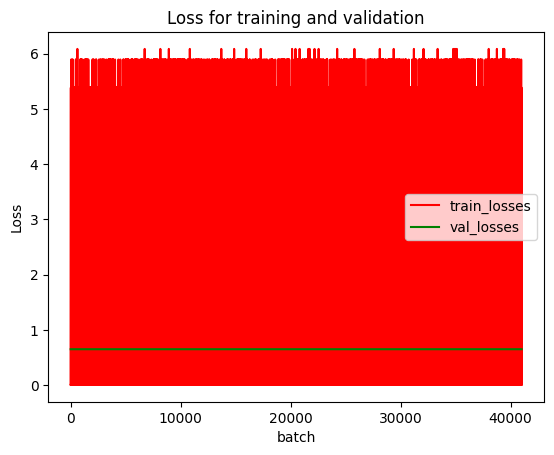

In [45]:
x = list(range(len(train_losses)))

repetitions = len(train_losses) // len(val_losses)
extended_val_loss = [element for element in val_losses for _ in range(repetitions)]

remaining_elements = len(train_losses) % len(val_losses)
if remaining_elements > 0:
    extended_val_loss += val_losses[:remaining_elements]

plt.plot(x, train_losses, color='r', label='train_losses')
plt.plot(x, extended_val_loss, color='g', label='val_losses')

plt.title('Loss for training and validation')
plt.ylabel('Loss')
plt.xlabel('batch')

plt.legend()


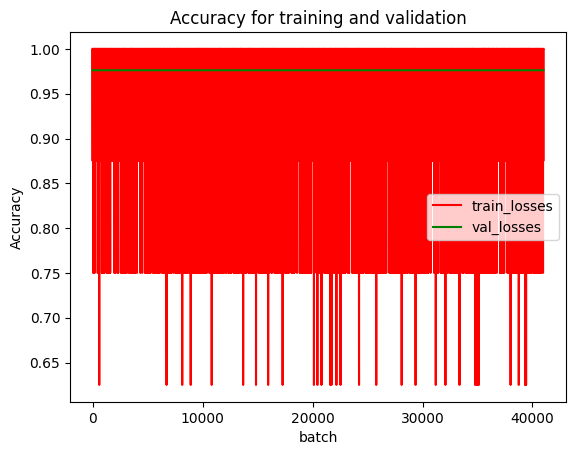

In [46]:
x = list(range(len(train_accs)))

repetitions = len(train_accs) // len(val_accs)
extended_val_accs = [element for element in val_accs for _ in range(repetitions)]

remaining_elements = len(train_accs) % len(val_accs)
if remaining_elements > 0:
    extended_val_accs += val_accs[:remaining_elements]

plt.plot(x, train_accs, color='r', label='train_losses')
plt.plot(x, extended_val_accs, color='g', label='val_losses')

plt.title('Accuracy for training and validation')
plt.ylabel('Accuracy')
plt.xlabel('batch')

plt.legend()

### Confusion Matrix

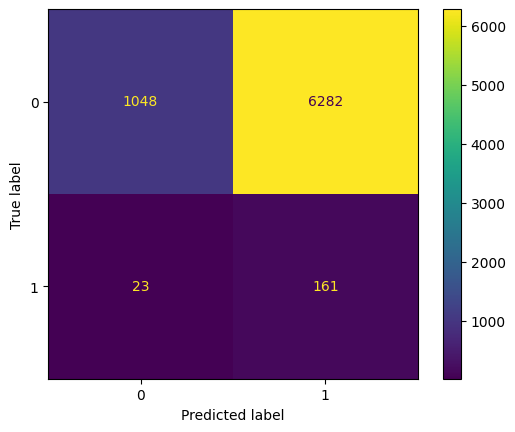

In [26]:
numpy_arrays = [t.cpu().numpy() for t in preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(labels, preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

### F1-score and AUC

In [28]:
f1 = metrics.f1_score(labels, preds)
auc = metrics.roc_auc_score(labels, preds)
print('f1: ', f1)
print('auc: ', auc)

f1:  0.04858910517579599
auc:  0.5089870395634379


### Precision, Recall and Accuracy

In [29]:
precision = metrics.precision_score(labels, preds)
recall = metrics.recall_score(labels, preds)
accuracy = metrics.accuracy_score(labels, preds)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)

precision:  0.02498835945987894
recall:  0.875
accuracy:  0.16089965397923875


### ROC-curve, FPR and TPR thresholds

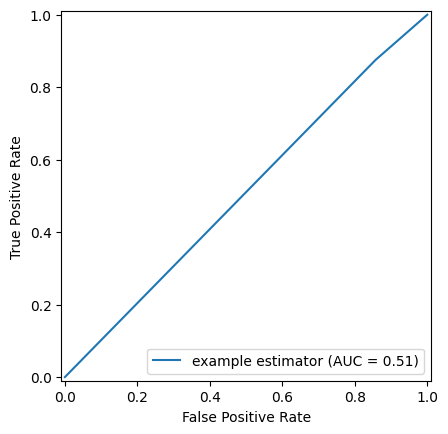

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

display.plot()